# Course 2 - 改善深层神经网络 - 第一周作业(2) - 正则化
1. 初始化参数：
	* 使用0来初始化参数。
	* 使用随机数来初始化参数。
	* 使用抑梯度异常初始化参数（参见视频中的梯度消失和梯度爆炸）。
2. 正则化模型：
	* 使用二范数对二分类模型正则化，尝试避免过拟合。 (`L2正则化`)
	* 使用随机删除节点的方法精简模型，同样是为了尝试避免过拟合。(`dropout正则化`)
3. 梯度校验  ：对模型使用梯度校验，检测它是否在梯度下降的过程中出现误差过大的情况。

在深度学习中，如果数据集没有足够大的话，可能会导致一些过拟合的问题。过拟合导致的结果就是在训练集上有着很高的精确度，但是在遇到新的样本时，精确度下降会很严重。为了避免过拟合的问题，接下来我们要讲解的方式就是正则化。


## 正则化模型
> Problem Statement: You have just been hired as an AI expert by the French Football Corporation. They would like you to recommend positions where France’s goal keeper should kick the ball so that the French team’s players can then hit it with their head.

问题描述：假设你现在是一个AI专家，你需要设计一个模型，可以用于推荐在足球场中守门员将球发至哪个位置可以让本队的球员抢到球的可能性更大。说白了，实际上就是一个二分类，一半是己方抢到球，一半就是对方抢到球，我们来看一下这个图：
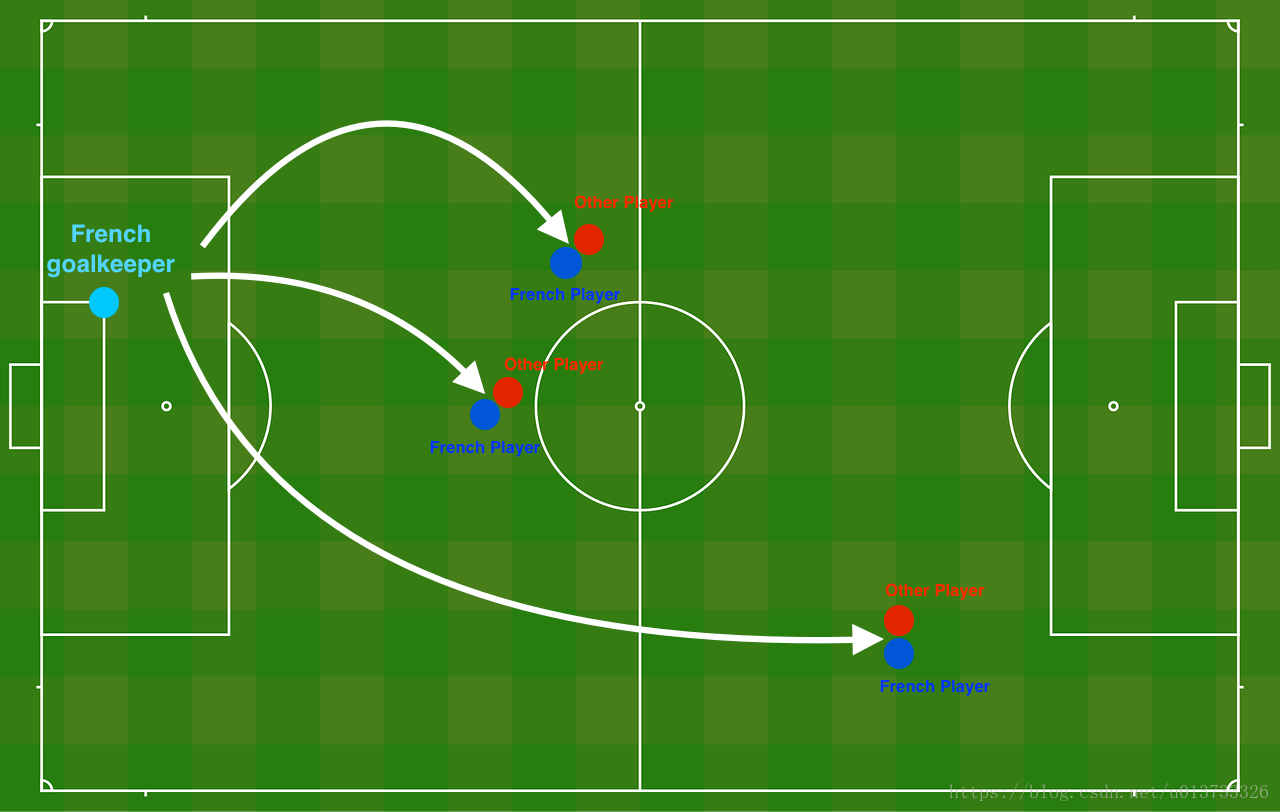

## 导入相关库

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import reg_utils    #第二部分，正则化
%matplotlib inline

plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'